<br>
<h1 style="color:#00acee; font-family:lato; font-size:300%; text-align:center;"> 
    Twitter
</h1>

***

In this project I want to do some analysis on tweets related to the [**#LoveIsNotTourism** movement](https://www.loveisnottourism.org/) ❤. 

In [1]:
# !pip install GetOldTweets3 #If you need to install this package, uncomment this line and run it
import GetOldTweets3 as got 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re 
from datetime import timedelta
import datetime
# Necessary to plot timeseries:
pd.plotting.register_matplotlib_converters()

The GetOldTweets3 package is really nice because it allows you to look for very old tweets (as opposed to the free version of the API from twitter). However, the downside is that it has less functionality.

Nonetheless, as we shall see, this package provides enough functionality to make a nice analysis about a specific topic.

GOT3 allows some criteria one can make use of to search on the Twit-sphere 
<img src='https://miro.medium.com/max/576/1*xVu-oaDRWW4yWF7yZ8W4Xw.png'>

# Own tweets 
To start trying out this package, first I would like to have a look at my latest tweets

## Search criteria
This is how to make a search on Twitter with GetOldTweets3

In [2]:
%%time
# First let's set some criteria search
username='@leopoldo_cus'
count=1000
interesting_text=''# '#LoveIsNotTourism'

# This is how to make a search on Twitter with GetOldTweets3
tweetCriteria = got.manager.TweetCriteria().setUsername(username).setMaxTweets(count).setQuerySearch(interesting_text).setEmoji("unicode")
# List of twits 
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

Wall time: 14.6 s


## Creating a dataframe

We have a list of twitter objects and would like now to create lists which will enable us to put a dataframe together. 

We will define a function that translates a list of tweet objects into a friendly, understandable pandas dataframe

In [3]:
%%time
def TweetDataframe(tweets):
    text = []
    usr = []
    rt=[]
    fav=[]
    ht=[]
    mentions=[]
    id_ = []
    date=[]
    # geo=[]
    for i in range(len(tweets)):
    #     print('{} \n '.format(got.manager.TweetManager.getTweets(tweetCriteria)[i].text ) )
        id_.append( tweets[i].id )
        text.append( tweets[i].text )
        usr.append(  tweets[i].username )
        rt.append( tweets[i].retweets )
        ht.append( tweets[i].hashtags )
        mentions.append( tweets[i].mentions )
        fav.append( tweets[i].favorites )
        date.append(tweets[i].date)
        #     geo.append( tweets[i].geo )

    # Create dataframe
    df = pd.DataFrame.from_dict({'date':date, 'usr':usr, 'ht':ht, 'mentions':mentions, 'rt':rt, 'fav':fav, 'text':text, 'ind':id_ } )
    df = df.set_index('ind')
    
    return df

df_leo = TweetDataframe(tweets)


Wall time: 9.97 ms


In [4]:
# Remove known ads
ads_usr = ['MovistarMX', 'danielchayau']
df_leo=df_leo[ ~df_leo.usr.isin(ads_usr) ]

# df_leo.head()

In [5]:
# Check out all the users:
df_leo.usr.unique()

array(['leopoldo_cus'], dtype=object)

### Plot

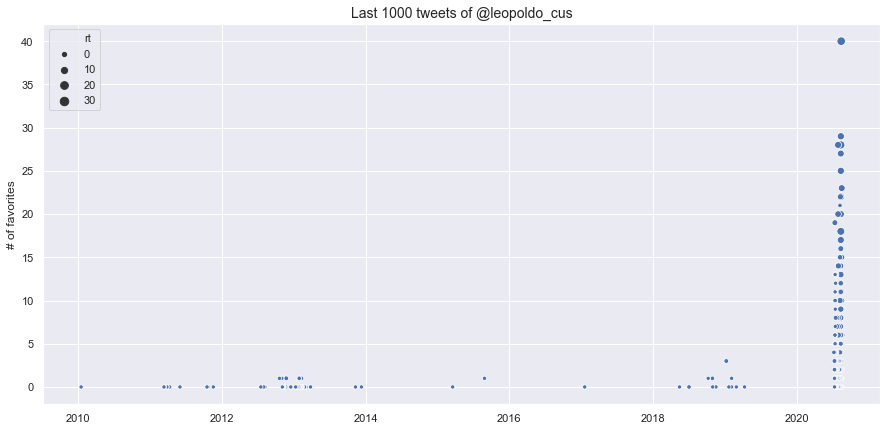

In [6]:
sns.set()
plt.figure(figsize=(15,7))
sns.scatterplot(x='date', y='fav', size='rt', data=df_leo)
plt.ylabel('# of favorites');
plt.xlabel('')
plt.title('Last {} tweets of {}'.format(count, username), size=14);
# sns.scatterplot(x='date', y='rt', data=df)

# #LoveIsNotTourism analysis

In [7]:
%%time

# Create empty dataframe
df = pd.DataFrame(columns = ['date', 'usr', 'ht', 'mentions', 'rt', 'fav', 'text', 'top_usr','ind'])
df = df.set_index('ind')

# 🔥 Search Criteria. This is the place to change the topic, hashtag or so
count= 1e5 #1e5
interesting_text='#LoveIsNotTourism'# AND @robersperanza' 
today = datetime.datetime.today()
days = 5

for i in range(days):
    
    end_date = (today + timedelta(-i)).strftime('%Y-%m-%d') # End date to search
    start_date = (today + timedelta(-i-1)).strftime('%Y-%m-%d')
    
    # This is how to make a search on Twitter with GetOldTweets3
    tweetCriteria = got.manager.TweetCriteria()\
                    .setMaxTweets(count)\
                    .setQuerySearch(interesting_text)\
                    .setEmoji("unicode")\
                    .setSince(start_date)\
                    .setUntil(end_date)
    #                 .setQuerySearch(mention)\
    # List of twits 
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Create DataFrame with previously defined function
    current_df = TweetDataframe(tweets)
    # Append current_df to df
    df = pd.concat([df,current_df])

Wall time: 10min 36s


## Remove ads

In [8]:
%%time 
# Remove known ads (this depends more on the IP address from where you run these queries and  )
ads_usr = ['MovistarMX', 'danielchayau', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism', 'VOANoticias','MasayukiTsuda2']
df = df[ ~df.usr.isin(ads_usr) ]

Wall time: 13 ms


In [9]:
%%time
# Select top users
top_users = df.sort_values(by=['fav','rt'], ascending=False).usr.unique()[:5].tolist()
df['top_usr'] = df['usr'].apply(lambda x: top_users.index(x)+1 if (x in top_users) else 0)

Wall time: 26.9 ms


## Time Series Plot
Let's take a look at the time behaviour of tweets discussing **#LoveIsNotTourism**

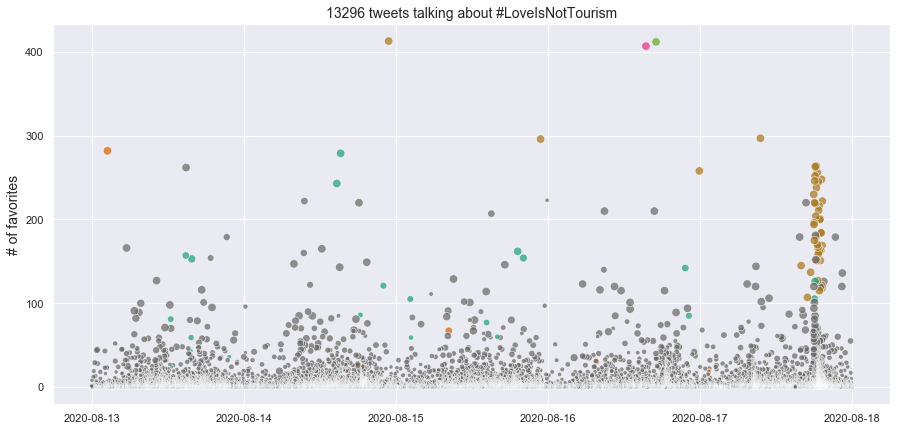

In [10]:
plt.figure(figsize=(15,7))

# sns.set()
# Colours
sns.set_palette("husl")


sns.scatterplot(x='date', y='fav', hue='top_usr', size=df.rt.astype('float'), size_norm=(5,50), data=df, 
                palette='Dark2_r', alpha=.7, legend=False)
plt.ylabel('# of favorites', size=14);
plt.xlabel('')
plt.title('{:.0f} tweets talking about {}'.format(len(df), interesting_text), 
          size=14);

# Tweets per day

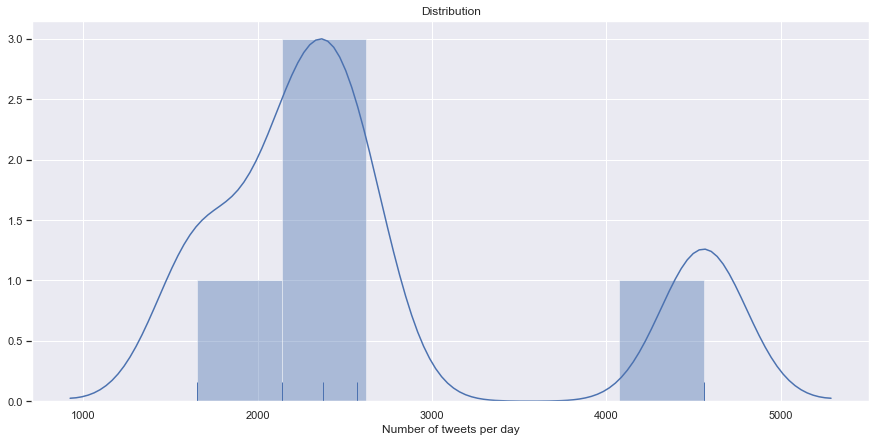

In [11]:
# df.resample('H', on='timestamps').mean()
sns.set()
plt.figure(figsize=(15,7))
plt.title('Distribution')

# Plotting hist without kde
ax = sns.distplot( df.resample('d', on='date').count().usr ,label='Count', kde=False);
# Creating another Y axis
second_ax = ax.twinx()

#Plotting kde without hist on the second Y axis
sns.distplot( df.resample('d', on='date').count().usr , ax=second_ax, rug=True, kde=True, hist=False);
#Removing Y ticks from the second axis
second_ax.set_yticks([]);
ax.set_xlabel('Days distribution');
ax.set_xlabel('Number of tweets per day');

## Most engaging Tweets

In [ ]:
df


In [18]:
# df_love.columns
# len(df_love)
# df_love[df_love.date<'2020-05']
# df_love[df_love.fav>500]
pd.set_option('display.max_colwidth', None)
df[df.fav>50].sort_values(['fav','rt'], ascending=False).loc[:,['date','usr','rt','fav','text']]

,date,usr,rt,fav,text
ind,,,,,
1294406878747860994,2020-08-14 22:53:43+00:00,LovesNotTourism,205,413,"So how long are you planning on keeping us apart? A year? 2? There are safe and easy ways to reunite us with our loved ones and family. This is not about Corona anymore, this is about awful politics. You have forgotten what it means to be human. #LoveIsNotTourism @EU_Commission"
1295044123716653056,2020-08-16 17:05:54+00:00,EricHerbst,249,412,"As you enjoy your Sunday with your significant other/boyfriend/girlfriend/family, take a moment to think about the thousands of binational couples and families who have been separated for 160+ days and have no end date in sight. Support #LoveIsNotTourism #LoveIsEssential"
1295020146344460288,2020-08-16 15:30:37+00:00,VoltEuropa,205,407,Imagine a pandemic hits the planet and you can't even find love and comfort with your partner... This reality affects thousands of bi-national couples. @VoltEuropa stands up for #LoveIsNotTourism; we demand immediate change while the #COVID19 restrictions are being respected.
1295293025241849857,2020-08-17 09:34:57+00:00,LovesNotTourism,166,297,"‼️REMINDER‼️ Love is Essential more than ever &amp; we are having another Twitter event TODAY, August 17th at 11AM PST/ 6PM GMT to open up the conversation about #LoveIsNotTourism for the many binational couples &amp; families that have been SEPARATED FOR MONTHS by the travel bans.PLS RT"
1294768955991535616,2020-08-15 22:52:29+00:00,LovesNotTourism,162,296,"🚨🚨 ALERT 🚨🚨 Join us for our 3RD GLOBAL TWITTER Q&amp;A event for #LOVEISNOTTOURISM this Monday, 17th of August at 11AM-12:00PM PST / 7PM-8:00PM UK! Let's do whatever we can to be heard and reunited with our loved ones!❤️ Be ready to Tweet like crazy and trend!! ENOUGH is ENOUGH!"
...,...,...,...,...,...
1293755058333446144,2020-08-13 03:43:37+00:00,jesszaro,13,52,"I just wanted to say a special thank you to @FacesofAdvocacy &amp; the team members who are working so hard &amp; who made today happen! Without this whole team, I don't know where we would all be without the help of everyone 💐❤️🙏 #LoveIsNotTourism #LoveIsEssential"
1294149873558749184,2020-08-14 05:52:28+00:00,SabkochKoch,29,51,Mallorca: 7-Tage-Inzidenz steigt auf 80! War abzusehen nach dem Verhalten deutscher Touristen in einem anderen Land. Aber Partner dürfen immer noch nicht alle einreisen mit Test! @BMISprecher @BMI_Bund @HeikoMaas @AuswaertigesAmt #LoveIsNotTourism #LoveIsEssential
1293867859563687936,2020-08-13 11:11:51+00:00,M_Crugliano,29,51,#LoveIsNotTourism #LoveIsEssential Reunification can be safe!! @GiuseppeConteIT @realDonaldTrump


# Export dataframe 

In [19]:
# Save the dfs to disk so that we can make use of it in Tableau 
df.to_csv('C:\\Users\\cuspi\\Documents\\Databases\\Twitter\\twitter_lint.csv')

# Sentiment analysis

# NLP-ML

# Working station

In [60]:
%%time

# Create empty dataframe
df = pd.DataFrame(columns = ['date', 'usr', 'ht', 'mentions', 'rt', 'fav', 'text', 'top_usr','ind'])
df = df.set_index('ind')

# Let's set some criteria search
count= 1e3 #1e5
interesting_text='#LoveIsNotTourism'# AND @robersperanza' 
today = datetime.datetime.today()
days = 5

for i in range(days):
    
    end_date = (today + timedelta(-i)).strftime('%Y-%m-%d')
    start_date = (today + timedelta(-i-1)).strftime('%Y-%m-%d')
    
    # This is how to make a search on Twitter with GetOldTweets3
    tweetCriteria = got.manager.TweetCriteria()\
                    .setMaxTweets(count)\
                    .setQuerySearch(interesting_text)\
                    .setEmoji("unicode")\
                    .setSince(start_date)\
                    .setUntil(end_date)
    #                 .setQuerySearch(mention)\
    # List of twits 
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Create DataFrame with previously defined function
    current_df = TweetDataframe(tweets)
    # Append current_df to df
    df = pd.concat([df,current_df])
    
# Remove known ads
ads_usr = ['MovistarMX', 'danielchayau', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism']
df = df[ ~df.usr.isin(ads_usr) ]

df

Wall time: 3min 52s


,date,usr,ht,mentions,rt,fav,text,top_usr
ind,,,,,,,,
1295510539297333250,2020-08-17 23:59:16+00:00,AmandaR515,#LoveIsNotTourism,@Sethrogen,0,0,@Sethrogen Please help us out! #LoveIsNotTourism,NaN
1295510108265381889,2020-08-17 23:57:33+00:00,yarellycn,#LoveIsNotTourism,@francediplo,1,0,Pourquoi rendre le processus un enfer? 3-5 sem...,NaN
1295509988740419584,2020-08-17 23:57:05+00:00,LyssaLouis,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry,@realDonaldTrump @StateDept @TravelGov @SecAza...,4,5,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry @r...,NaN
1295509692307865607,2020-08-17 23:55:54+00:00,JenzKSch,#ResumeK1Visa #LoveIsNotTourism,,3,10,Intact tag from my return trip earlier this ye...,NaN
1295509412803743745,2020-08-17 23:54:48+00:00,tapho07,#visa_regroupement_algerien #LoveIsNotTourism,,1,0,"#visa_regroupement_algerien, 547 Nous sommes d...",NaN
...,...,...,...,...,...,...,...,...
1293929458005573632,2020-08-13 15:16:37+00:00,nildecreus98,#LoveIsNotTourism,,0,0,#LoveIsNotTourism,NaN
1293929417555632130,2020-08-13 15:16:27+00:00,hej0995,#LoveIsNotTourism #LiftTheTravelBanPH,@dododulay @teddyboylocsin @DFAPHL @immigrationPH,1,1,Yes please 😭🙏🏼🙏🏼🙏🏼 #LoveIsNotTourism #LiftTheT...,NaN
1293929316984795136,2020-08-13 15:16:03+00:00,Kaylee83545080,#LoveIsNotTourism #LoveIsEssential,@FacesofAdvocacy,1,8,Thank you Jack and the entire NDP for your sup...,NaN


In [61]:
%%time
# Select top users
top_users = df.sort_values(by=['fav','rt'], ascending=False).usr.unique()[:5].tolist()
df['top_usr'] = df['usr'].apply(lambda x: top_users.index(x)+1 if (x in top_users) else 0)

Wall time: 21 ms


In [62]:
df

,date,usr,ht,mentions,rt,fav,text,top_usr
ind,,,,,,,,
1295510539297333250,2020-08-17 23:59:16+00:00,AmandaR515,#LoveIsNotTourism,@Sethrogen,0,0,@Sethrogen Please help us out! #LoveIsNotTourism,0
1295510108265381889,2020-08-17 23:57:33+00:00,yarellycn,#LoveIsNotTourism,@francediplo,1,0,Pourquoi rendre le processus un enfer? 3-5 sem...,0
1295509988740419584,2020-08-17 23:57:05+00:00,LyssaLouis,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry,@realDonaldTrump @StateDept @TravelGov @SecAza...,4,5,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry @r...,0
1295509692307865607,2020-08-17 23:55:54+00:00,JenzKSch,#ResumeK1Visa #LoveIsNotTourism,,3,10,Intact tag from my return trip earlier this ye...,0
1295509412803743745,2020-08-17 23:54:48+00:00,tapho07,#visa_regroupement_algerien #LoveIsNotTourism,,1,0,"#visa_regroupement_algerien, 547 Nous sommes d...",0
...,...,...,...,...,...,...,...,...
1293929458005573632,2020-08-13 15:16:37+00:00,nildecreus98,#LoveIsNotTourism,,0,0,#LoveIsNotTourism,0
1293929417555632130,2020-08-13 15:16:27+00:00,hej0995,#LoveIsNotTourism #LiftTheTravelBanPH,@dododulay @teddyboylocsin @DFAPHL @immigrationPH,1,1,Yes please 😭🙏🏼🙏🏼🙏🏼 #LoveIsNotTourism #LiftTheT...,0
1293929316984795136,2020-08-13 15:16:03+00:00,Kaylee83545080,#LoveIsNotTourism #LoveIsEssential,@FacesofAdvocacy,1,8,Thank you Jack and the entire NDP for your sup...,0


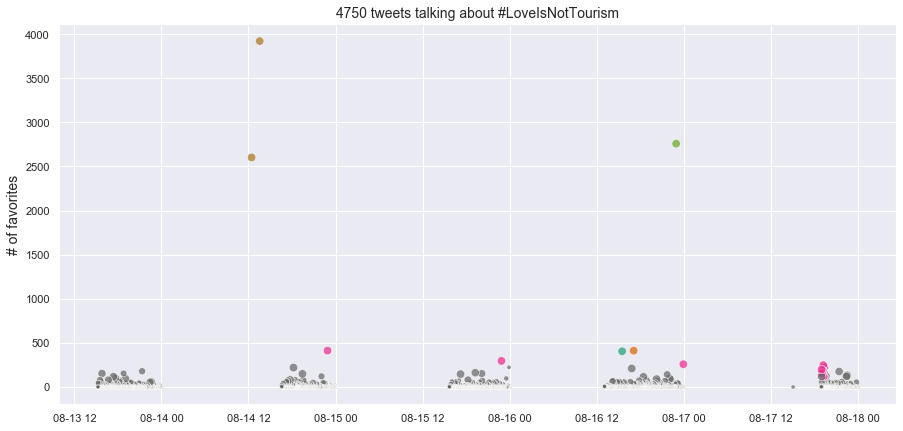

In [63]:
plt.figure(figsize=(15,7))

sns.set()
# Colours
# sns.set_palette("autumn")


sns.scatterplot(x='date', y='fav', hue='top_usr', size=df.rt.astype('float'), size_norm=(5,50), data=df, 
                palette='Dark2_r', alpha=.7, legend=False)
plt.ylabel('# of favorites', size=14);
plt.xlabel('')
plt.title('{:.0f} tweets talking about {}'.format(len(df), interesting_text), 
          size=14);